# Homework 3

In [291]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree

In [292]:
# read in csv file
algae_monthly = pd.read_csv('algae_monthly.csv')
# drop first column since it repeats index
algae_monthly.drop(columns=algae_monthly.columns[0], axis=1, inplace=True)

In [320]:
algae_monthly.head()

,reservoir,order,yearmonth,density_cells/ml,m_avg_deep_temp,m_avg_surf_temp,m_avg_dissolved_oxygen,temperature,precipitation_sum,daylight_duration,type,stratification,latitude,longitude,temp_diff
0,BHR,Chroococcales,199206,1630.434783,18.641379,23.762500,6.041379,20.540000,3.580000,52903.894000,Forest,Strong,37.3386,-83.4707,5.121121
1,BHR,Chroococcales,199307,111.428571,21.703571,30.925000,0.885714,27.074194,2.283871,51969.053548,Forest,Strong,37.3386,-83.4707,9.221429
2,BHR,Chroococcales,199807,3.295680,21.683333,28.583333,1.262500,24.312903,2.032258,51984.238710,Forest,Strong,37.3386,-83.4707,6.900000
3,BHR,Chroococcales,200306,215.295238,18.387097,23.937500,5.861290,20.513333,5.406667,52892.536333,Forest,Strong,37.3386,-83.4707,5.550403
4,BHR,Chroococcales,200606,3.390667,17.814286,25.675000,5.021429,21.473333,3.690000,52897.074000,Forest,Strong,37.3386,-83.4707,7.860714


In [294]:
# check null values
algae_monthly.isnull().sum()

reservoir                   0
order                       0
yearmonth                   0
density_cells/ml            0
m_avg_deep_temp             0
m_avg_surf_temp             0
m_avg_dissolved_oxygen      0
temperature                 0
precipitation_sum           0
daylight_duration           0
type                        0
stratification            189
latitude                    0
longitude                   0
temp_diff                   0
dtype: int64

In [295]:
# replace stratification null values with "no stratification"
algae_monthly['stratification'].fillna("No Stratification", inplace = True)

## Naive Bayes
* Attempt to use Naive Bayes to predict order based on algae bloom and reservoir observations.
* I will use stratification, type, reservoir, algae density, dissolved oxygen, temperature, precipitation, and temp_diff

### Data Prep
Since I have a combination of categorical and numerical data, I am going to split the numerical data into bins to "create" categories. 

In [296]:
# create a function that takes a list and splits into very low = 0, low = 1, medium = 2, high = 3, very high = 4 using 20th percentiles

def cat_numeric(list):
    vl = np.percentile(list, 20) # cut off bw very low and low
    l = np.percentile(list, 40) # cut off bw low and medium
    m = np.percentile(list, 60) # cut off bw medium and high
    h = np.percentile(list, 80) # cut off bw high and very high

    cat = []
    for i in range(len(list)):
        v = list[i]
        if v <= vl:
            cat.append(0)
        elif v <= l:
            cat.append(1)
        elif v <= m:
            cat.append(2) 
        elif v <= h:
            cat.append(3)
        else:
            cat.append(4)
    return cat


In [297]:
# categorize numeric data and store into lists
do_cat = cat_numeric(algae_monthly['m_avg_dissolved_oxygen'])
algconc_cat = cat_numeric(algae_monthly['density_cells/ml'])
temp_cat = cat_numeric(algae_monthly['temperature'])
temp_diff_cat = cat_numeric(algae_monthly['temp_diff'])
precip_cat = cat_numeric(algae_monthly['precipitation_sum'])
daylight_cat = cat_numeric(algae_monthly['daylight_duration'])

In [298]:
# label encode categorical data to numeric values
label_encoder = LabelEncoder()
order_enc = label_encoder.fit_transform(algae_monthly['order'])
order_labels = label_encoder.classes_
strat_enc = label_encoder.fit_transform(algae_monthly['stratification'])
strat_labels = label_encoder.classes_
res_enc = label_encoder.fit_transform(algae_monthly['reservoir'])
type_enc = label_encoder.fit_transform(algae_monthly['type'])

In [299]:
# create new data frame
algae_cat = pd.DataFrame({'algae_conc':algconc_cat, 'order':order_enc, 'stratification':strat_enc, 'type':type_enc, 'reservoir':res_enc, 'do':do_cat,
                           'temp':temp_cat, 'temp_diff':temp_diff_cat, 'precip':precip_cat, 'daylight':daylight_cat})

In [300]:
algae_cat

,algae_conc,order,stratification,type,reservoir,do,temp,temp_diff,precip,daylight
0,3,0,1,1,0,4,0,2,3,4
1,1,0,1,1,0,1,4,3,1,2
2,0,0,1,1,0,2,3,2,1,3
3,2,0,1,1,0,4,0,2,4,4
4,0,0,1,1,0,4,1,3,3,4
...,...,...,...,...,...,...,...,...,...,...
574,4,1,0,2,4,0,1,0,1,0
575,4,1,0,2,4,3,1,0,4,4
576,4,4,0,2,4,0,1,0,1,0
577,4,4,0,2,4,3,1,0,4,4


In [301]:
# export as a csv file
algae_cat.to_csv('algae_cat.csv')

### Create Train and Test Data

In [337]:
# split into predictors and class
y = algae_cat['algae_conc'] # this is our class data
# get predictors. Note this is all but the first column
predictors = algae_cat.columns 
predictors = predictors[1:]
x = algae_cat[predictors]

# use train_test_split to create the testing and training data
NB_x_train, NB_x_test, NB_y_train, NB_y_test = train_test_split(x, y, test_size=0.3, random_state=0) # complete a 70-30 split


In [338]:
# export the training and testing data
NB_x_train.to_csv('NB_x_train.csv')
NB_y_train.to_csv('NB_y_train.csv')
NB_x_test.to_csv('NB_x_test.csv')
NB_y_test.to_csv('NB_y_test.csv')

### Create and Run the Model

In [341]:
# create the model
mnb = MultinomialNB()
# fit the model
model = mnb.fit(NB_x_train, NB_y_train) 
# make predictions with the model
NB_y_pred = model.predict(x_test)

### Check Accuracy and Confusion Matrix

In [342]:
# check for accuracy
print(f'Model accuracy score: {100*accuracy_score(NB_y_test, NB_y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (NB_x_test.shape[0], (NB_y_test != NB_y_pred).sum())) 

Model accuracy score: 24.71%
Number of mislabeled points out of a total 174 points : 131


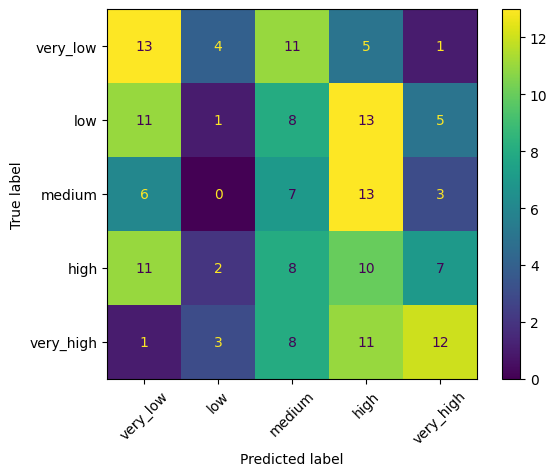

In [343]:
cm = confusion_matrix(NB_y_test, NB_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['very_low', 'low', 'medium', 'high', 'very_high'])
disp.plot(xticks_rotation=45)

## Decision Trees

#### Decision Tree 1
Classifying algae concentration with all other features in the algae_cat dataframe

In [353]:
algae_cat.columns

Index(['algae_conc', 'order', 'stratification', 'type', 'reservoir', 'do',
       'temp', 'temp_diff', 'precip', 'daylight'],
      dtype='object')

In [354]:
# create training and testing data
features_dt = ['order', 'stratification', 'type', 'reservoir', 'do', 'temp', 'temp_diff', 'precip', 'daylight']
y_dt = algae_cat['algae_conc']
x_dt = algae_cat[features_dt]

# use train_test_split to create the testing and training data
dt1_x_train, dt1_x_test, dt1_y_train, dt1_y_test = train_test_split(x_dt, y_dt, test_size=0.3, random_state=12) # complete a 70-30 split

In [355]:
# export the training and testing data
dt1_x_train.to_csv('dt1_x_train.csv')
dt1_y_train.to_csv('dt1_y_train.csv')
dt1_x_test.to_csv('dt1_x_test.csv')
dt1_y_test.to_csv('dt1_y_test.csv')

In [364]:
dt1_y_test.head()

338    3
212    1
78     0
201    2
14     0
Name: algae_conc, dtype: int64

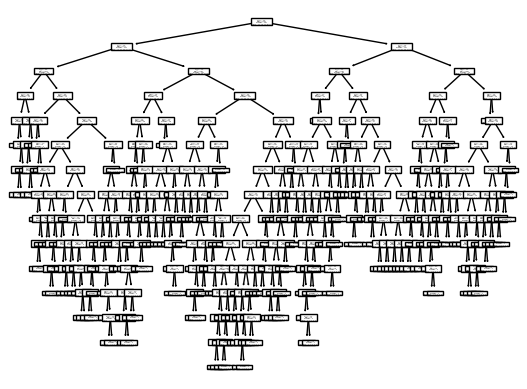

In [356]:
clf = tree.DecisionTreeClassifier()
dt1 = clf.fit(dt1_x_train, dt1_y_train)
tree.plot_tree(dt1);

In [357]:
dt1_y_pred = dt1.predict(x_test)

In [358]:
# check for accuracy
print(f'Model accuracy score: {100*accuracy_score(dt1_y_test, dt1_y_pred):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (dt1_x_test.shape[0], (dt1_y_test != dt1_y_pred).sum())) 

Model accuracy score: 20.69%
Number of mislabeled points out of a total 174 points : 138


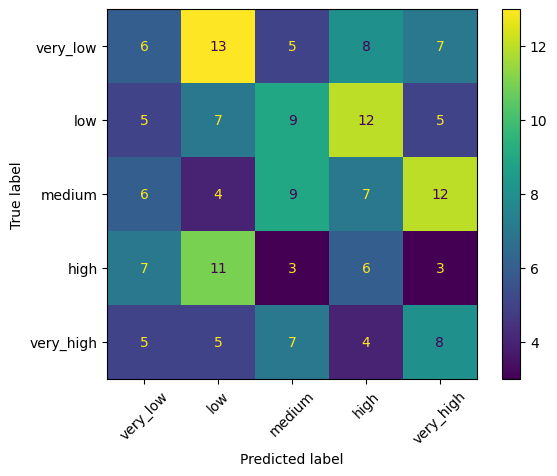

In [359]:
cm = confusion_matrix(dt1_y_test, dt1_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['very_low', 'low', 'medium', 'high', 'very_high']) # go get labels
disp.plot(xticks_rotation=45)

#### Decision Tree 2
Classifying algae concentration with the numerical features (dissolved oxygen, temperature, temp_diff, and precipitation)

In [404]:
# create training and testing data
features_dt2 = ['do', 'temp', 'temp_diff', 'precip']
y_dt2 = algae_cat['algae_conc']
x_dt2 = algae_cat[features_dt2]

# use train_test_split to create the testing and training data
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_dt2, y_dt2, test_size=0.3, random_state=12) # complete a 70-30 split

In [405]:
# export the training and testing data
x_train2.to_csv('dt2_x_train.csv')
y_train2.to_csv('dt2_y_train.csv')
x_test2.to_csv('dt2_x_test.csv')
y_test2.to_csv('dt2_y_test.csv')

In [406]:
y_test2.head()

338    3
212    1
78     0
201    2
14     0
Name: algae_conc, dtype: int64

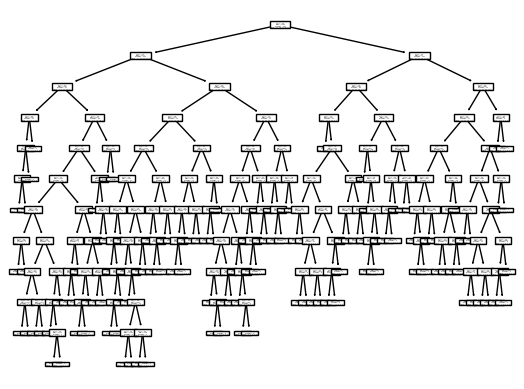

In [407]:
clf2 = tree.DecisionTreeClassifier()
dt2 = clf2.fit(x_train2, y_train2)
tree.plot_tree(dt2);

In [408]:
# Use tree to make prediction
y_pred2 = dt2.predict(x_test2)

# check for accuracy
print(f'Model accuracy score: {100*accuracy_score(y_test2, y_pred2):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test2.shape[0], (y_test2 != y_pred2).sum())) 

Model accuracy score: 33.91%
Number of mislabeled points out of a total 174 points : 115


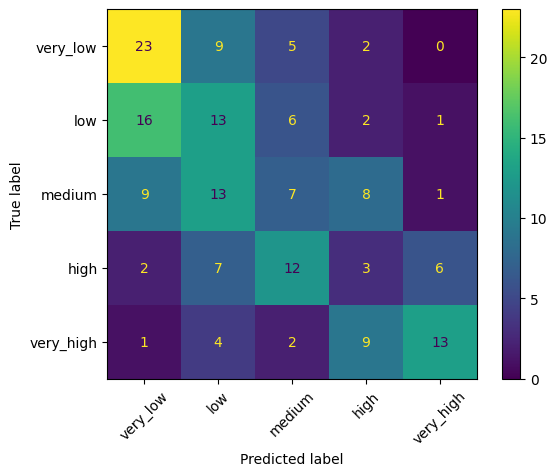

In [410]:
cm2 = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels = ['very_low', 'low', 'medium', 'high', 'very_high']) # go get labels
disp.plot(xticks_rotation=45)

#### Decision Tree 3
Classifying algae concentration with a mix of numerical and categorical features (dissolved oxygen, temp_diff, and stratification)

In [423]:
# create training and testing data
features_dt3 = ['do','temp_diff', 'stratification']
y_dt3 = algae_cat['algae_conc']
x_dt3 = algae_cat[features_dt3]

# use train_test_split to create the testing and training data
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_dt3, y_dt3, test_size=0.3, random_state=12) # complete a 70-30 split

In [424]:
# export the training and testing data
x_train3.to_csv('dt3_x_train.csv')
y_train3.to_csv('dt3_y_train.csv')
x_test3.to_csv('dt3_x_test.csv')
y_test3.to_csv('dt3_y_test.csv')

In [425]:
y_test3.head()

338    3
212    1
78     0
201    2
14     0
Name: algae_conc, dtype: int64

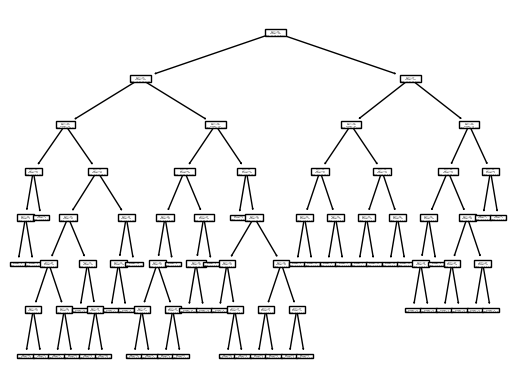

In [426]:
clf3 = tree.DecisionTreeClassifier()
dt3 = clf3.fit(x_train3, y_train2)
tree.plot_tree(dt3);

In [427]:
# Use tree to make prediction
y_pred3 = dt3.predict(x_test3)

# check for accuracy
print(f'Model accuracy score: {100*accuracy_score(y_test3, y_pred3):0.2f}%')
print("Number of mislabeled points out of a total %d points : %d"
% (x_test3.shape[0], (y_test3 != y_pred3).sum())) 

Model accuracy score: 32.76%
Number of mislabeled points out of a total 174 points : 117


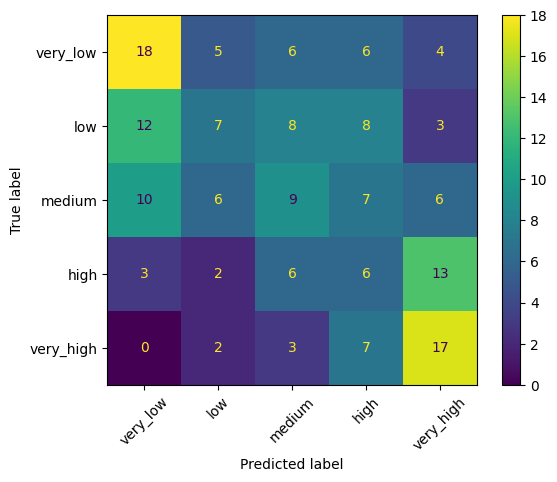

In [428]:
cm3 = confusion_matrix(y_test3, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels = ['very_low', 'low', 'medium', 'high', 'very_high']) # go get labels
disp.plot(xticks_rotation=45)